### Short script to test heat and salt budget closure in the Baltic Sea config

In [62]:
import xarray as xr
from matplotlib import pyplot as plt
import budgetcalcs as bc
import numpy as np
import cartopy.crs as ccrs

In [63]:
rootdir = '/archive/gam/MOM6-examples/ice_ocean_SIS2/Baltic_OM4_025_ashao-orig/'
filename_native = '19000101.ocean_daily.nc'
filename_rho2 = '19000101.ocean_daily_rho2.nc'
filename_z = '19000101.ocean_daily_z.nc'
filename_grid = '19000101.ocean_static.nc'
ds_native = xr.open_dataset(rootdir+filename_native,decode_times=False).isel(time=1)
ds_rho2 = xr.open_dataset(rootdir+filename_rho2,decode_times=False).isel(time=1)
ds_z = xr.open_dataset(rootdir+filename_z,decode_times=False).isel(time=1)
grid = xr.open_dataset(rootdir+filename_grid)

In [64]:
# Calculate the budgets, evaluate errors, merge to datasets
### HEAT ###
heat_terms = ['opottemptend','T_advection_xy','Th_tendency_vert_remap','boundary_forcing_heat_tendency','internal_heat_heat_tendency','opottempdiff','opottemppmdiff','frazil_heat_tendency']
ds_native['tendsum_heat'],ds_native['error_heat'] = bc.calc_budget(ds_native,heat_terms[1:],heat_terms[0],vertc='zl',plot=False)
ds_z['tendsum_heat'],ds_z['error_heat'] = bc.calc_budget(ds_z,heat_terms[1:],heat_terms[0],vertc='z_l',plot=False)
ds_rho2['tendsum_heat'],ds_rho2['error_heat'] = bc.calc_budget(ds_rho2,heat_terms[1:],heat_terms[0],vertc='rho2_l',plot=False)
### SALT ###
salt_terms = ['osalttend','S_advection_xy','Sh_tendency_vert_remap','boundary_forcing_salt_tendency','osaltdiff','osaltpmdiff']
ds_native['tendsum_salt'],ds_native['error_salt'] = bc.calc_budget(ds_native,salt_terms[1:],salt_terms[0],vertc='zl',plot=False)
ds_z['tendsum_salt'],ds_z['error_salt'] = bc.calc_budget(ds_z,salt_terms[1:],salt_terms[0],vertc='z_l',plot=False)
ds_rho2['tendsum_salt'],ds_rho2['error_salt'] = bc.calc_budget(ds_rho2,salt_terms[1:],salt_terms[0],vertc='rho2_l',plot=False)

In [65]:
# Profile
x = 5
y = 64
prof_native = ds_native.sel(xh=x,yh=y,method='nearest')
prof_z = ds_z.sel(xh=x,yh=y,method='nearest')
prof_rho2 = ds_rho2.sel(xh=x,yh=y,method='nearest')
# Profile cumulative vertical sum
profvsum_native = prof_native.cumsum('zl')
profvsum_z = prof_z.cumsum('z_l')
profvsum_rho2 = prof_rho2.cumsum('rho2_l')
# Vertical sums
vsum_native = ds_native.sum('zl')
vsum_z = ds_z.sum('z_l')
vsum_rho2 = ds_rho2.sum('rho2_l')
# Horizontal sums
hsum_native = (ds_native*grid['areacello']).sum(['xh','yh'])
hsum_z = (ds_z*grid['areacello']).sum(['xh','yh'])
hsum_rho2 = (ds_rho2*grid['areacello']).sum(['xh','yh'])
# Horizontal and vertical cumulative sums
hvsum_native = hsum_native.cumsum('zl')
hvsum_z = hsum_z.cumsum('z_l')
hvsum_rho2 = hsum_rho2.cumsum('rho2_l')
# RMS error
# heat
rmse_heat_native = xr.ufuncs.sqrt((ds_native['error_heat']**2).mean(dim='zl'))
rmse_heat_z = xr.ufuncs.sqrt((ds_z['error_heat']**2).mean(dim='z_l'))
rmse_heat_rho2 = xr.ufuncs.sqrt((ds_rho2['error_heat']**2).mean(dim='rho2_l'))
# salt
rmse_salt_native = xr.ufuncs.sqrt((ds_native['error_salt']**2).mean(dim='zl'))
rmse_salt_z = xr.ufuncs.sqrt((ds_z['error_salt']**2).mean(dim='z_l'))
rmse_salt_rho2 = xr.ufuncs.sqrt((ds_rho2['error_salt']**2).mean(dim='rho2_l'))

/nbhome/gam/miniconda/envs/mom6-clean/lib/python3.8/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


In [66]:
def draw_cfgrid_pcolormesh(var_native,var_z,var_rho2,grid,clims):
    fig,(ax_native,ax_z,ax_rho2) = plt.subplots(figsize=(20,7),ncols=3,subplot_kw={'projection':ccrs.PlateCarree()})
    im = ax_native.pcolormesh(grid['xh'],grid['yh'],var_native,vmin=clims[0],vmax=clims[1])
    ax_native.set_title('native')
    plt.colorbar(im,ax=ax_native,fraction=0.02)
    im = ax_z.pcolormesh(grid['xh'],grid['yh'],var_z,vmin=clims[0],vmax=clims[1])
    ax_z.set_title('z')
    plt.colorbar(im,ax=ax_z,fraction=0.02)
    im = ax_rho2.pcolormesh(grid['xh'],grid['yh'],var_rho2,vmin=clims[0],vmax=clims[1])
    ax_rho2.set_title('rho2')
    plt.colorbar(im,ax=ax_rho2,fraction=0.02)
    
def draw_cfrun_pcolormesh(var_old,var_new,grid,clims,clims_diff):
    fig,(ax_old,ax_new,ax_oldnew) = plt.subplots(figsize=(20,7),ncols=3,subplot_kw={'projection':ccrs.PlateCarree()})
    im = ax_old.pcolormesh(grid['xh'],grid['yh'],var_old,vmin=clims[0],vmax=clims[1])
    ax_old.set_title('old')
    plt.colorbar(im,ax=ax_old,fraction=0.02)
    im = ax_new.pcolormesh(grid['xh'],grid['yh'],var_new,vmin=clims[0],vmax=clims[1])
    ax_new.set_title('new')
    plt.colorbar(im,ax=ax_new,fraction=0.02)
    im = ax_oldnew.pcolormesh(grid['xh'],grid['yh'],var_old-var_new,vmin=clims[0]/10,vmax=clims[1]/10)
    ax_oldnew.set_title('old-new')
    plt.colorbar(im,ax=ax_oldnew,fraction=0.02)
    
def draw_cf_plot(var_native,var_z,var_rho2,k_native,k_z,k_rho2):
    fig,ax = plt.subplots(figsize=(5,8),ncols=1)
    ax.plot(var_native,k_native,'.-',label='native')
    ax.plot(var_z,k_z,'.-',label='z')
    ax.plot(var_rho2,k_rho2,'.-',label='rho2')
    ax.invert_yaxis()
    ax.legend()

### Vertical sum of tendency (to gauge magnitude of terms)

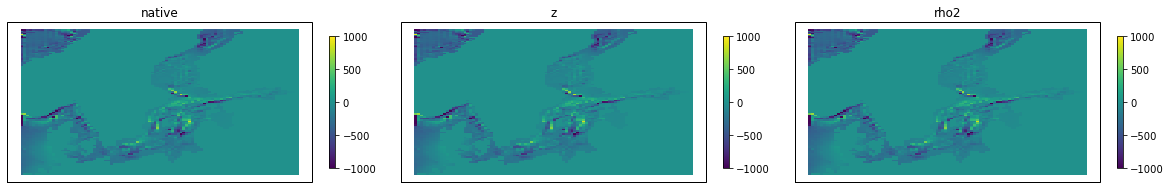

In [67]:
var = 'tendsum_heat'
clims = [-1000, 1000] # heat
# clims = [-1E-4,1E-4] # salt
draw_cfgrid_pcolormesh(vsum_native[var],vsum_z[var],vsum_rho2[var],grid,clims)

### Error in vertical sum

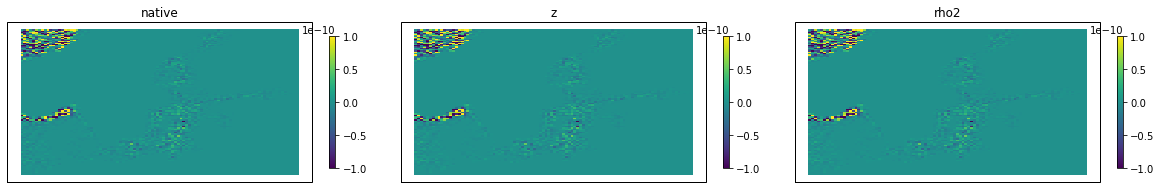

In [68]:
var = 'error_heat'
clims = [-1E-10,1E-10] # heat
# clims = [-1E-9,1E-9] # salt
draw_cfgrid_pcolormesh(vsum_native[var],vsum_z[var],vsum_rho2[var],grid,clims)

### Profile of area-integrated tendency

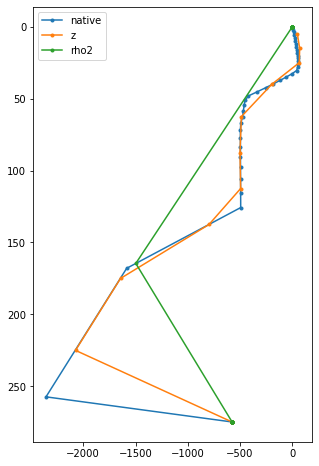

In [69]:
var = 'tendsum_heat'
draw_cf_plot(profvsum_native[var],profvsum_z[var],profvsum_rho2[var],profvsum_native['thkcello'],profvsum_z['thkcello'],profvsum_rho2['thkcello'])

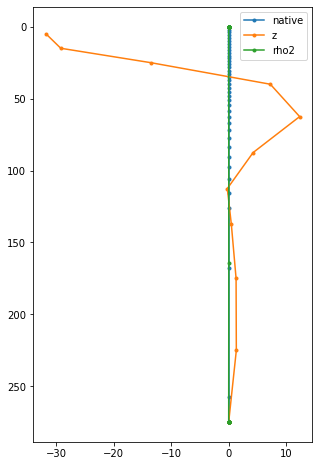

In [70]:
var = 'error_heat'
draw_cf_plot(profvsum_native[var],profvsum_z[var],profvsum_rho2[var],profvsum_native['thkcello'],profvsum_z['thkcello'],profvsum_rho2['thkcello'])

### Error in area-integrated budget

Text(0.5, 1.0, 'error_heat')

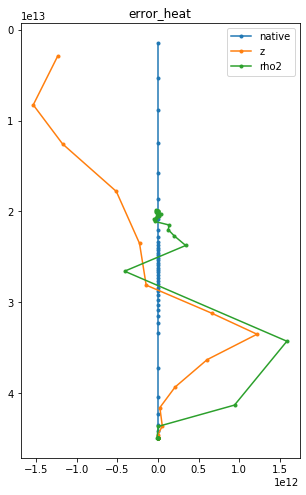

In [71]:
var = 'error_heat'
draw_cf_plot(hvsum_native[var],hvsum_z[var],hvsum_rho2[var],hvsum_native['thkcello'],hvsum_z['thkcello'],hvsum_rho2['thkcello'])
plt.gca().set_title('error_heat')

### Root-mean-square error (log10)

/nbhome/gam/miniconda/envs/mom6-clean/lib/python3.8/site-packages/xarray/core/computation.py:604: RuntimeWarning: divide by zero encountered in log10
  result_data = func(*input_data)


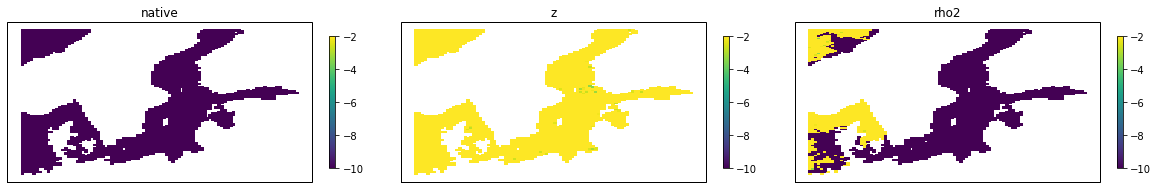

In [72]:
clims = [-10,-2]
draw_cfgrid_pcolormesh(np.log10(rmse_heat_native),np.log10(rmse_heat_z),np.log10(rmse_heat_rho2),grid,clims)

****
## Comparison to new output

In [73]:
rootdir_new = '/archive/gam/MOM6-examples/ice_ocean_SIS2/Baltic_OM4_025_ashao-new/'
ds_native_new = xr.open_dataset(rootdir_new+filename_native,decode_times=False).isel(time=1)
ds_rho2_new = xr.open_dataset(rootdir_new+filename_rho2,decode_times=False).isel(time=1)
ds_z_new = xr.open_dataset(rootdir_new+filename_z,decode_times=False).isel(time=1)
# Calculate the budgets, evaluate errors, merge to datasets
### HEAT ###
ds_native_new['tendsum_heat'],ds_native_new['error_heat'] = bc.calc_budget(ds_native_new,heat_terms[1:],heat_terms[0],vertc='zl',plot=False)
ds_z_new['tendsum_heat'],ds_z_new['error_heat'] = bc.calc_budget(ds_z_new,heat_terms[1:],heat_terms[0],vertc='z_l',plot=False)
ds_rho2_new['tendsum_heat'],ds_rho2_new['error_heat'] = bc.calc_budget(ds_rho2_new,heat_terms[1:],heat_terms[0],vertc='rho2_l',plot=False)
### SALT ###
ds_native_new['tendsum_salt'],ds_native_new['error_salt'] = bc.calc_budget(ds_native_new,salt_terms[1:],salt_terms[0],vertc='zl',plot=False)
ds_z_new['tendsum_salt'],ds_z_new['error_salt'] = bc.calc_budget(ds_z_new,salt_terms[1:],salt_terms[0],vertc='z_l',plot=False)
ds_rho2_new['tendsum_salt'],ds_rho2_new['error_salt'] = bc.calc_budget(ds_rho2_new,salt_terms[1:],salt_terms[0],vertc='rho2_l',plot=False)
# Vertical sums
vsum_native_new = ds_native_new.sum('zl')
vsum_z_new = ds_z_new.sum('z_l')
vsum_rho2_new = ds_rho2_new.sum('rho2_l')
# Horizontal sums
hsum_native_new = (ds_native_new*grid['areacello']).sum(['xh','yh'])
hsum_z_new = (ds_z_new*grid['areacello']).sum(['xh','yh'])
hsum_rho2_new = (ds_rho2_new*grid['areacello']).sum(['xh','yh'])
# RMS error
# heat
rmse_heat_native_new = xr.ufuncs.sqrt((ds_native_new['error_heat']**2).mean(dim='zl'))
rmse_heat_z_new = xr.ufuncs.sqrt((ds_z_new['error_heat']**2).mean(dim='z_l'))
rmse_heat_rho2_new = xr.ufuncs.sqrt((ds_rho2_new['error_heat']**2).mean(dim='rho2_l'))
# salt
rmse_salt_native_new = xr.ufuncs.sqrt((ds_native_new['error_salt']**2).mean(dim='zl'))
rmse_salt_z_new = xr.ufuncs.sqrt((ds_z_new['error_salt']**2).mean(dim='z_l'))
rmse_salt_rho2_new = xr.ufuncs.sqrt((ds_rho2_new['error_salt']**2).mean(dim='rho2_l'))

# Cumulative sum of area-integrated thickness
k_native_new = hsum_native_new['thkcello'].cumsum('zl')
k_z_new = hsum_z_new['thkcello'].cumsum('z_l')
k_rho2_new = hsum_rho2_new['thkcello'].cumsum('rho2_l')

/nbhome/gam/miniconda/envs/mom6-clean/lib/python3.8/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


### RMSE

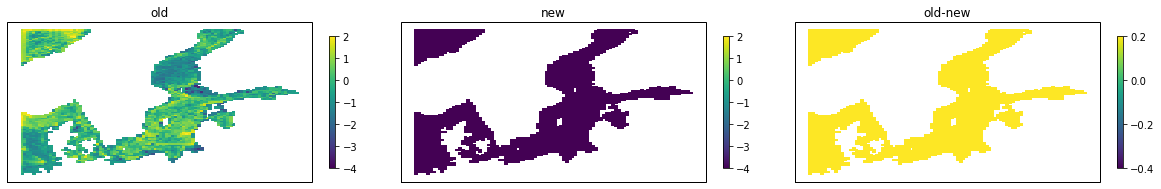

In [76]:
clims = [-4,2]
clims_diff = [-1E-1, 1E-1]
draw_cfrun_pcolormesh(np.log10(rmse_heat_z),np.log10(rmse_heat_z_new),grid,clims,clims_diff)

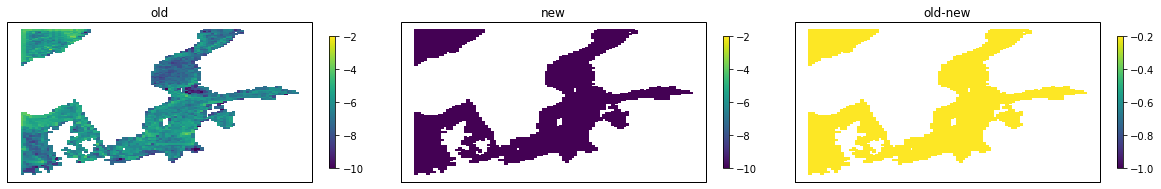

In [77]:
clims = [-10,-2]
clims_diff = [-1E-1, 1E-1]
draw_cfrun_pcolormesh(np.log10(rmse_salt_z),np.log10(rmse_salt_z_new),grid,clims,clims_diff)

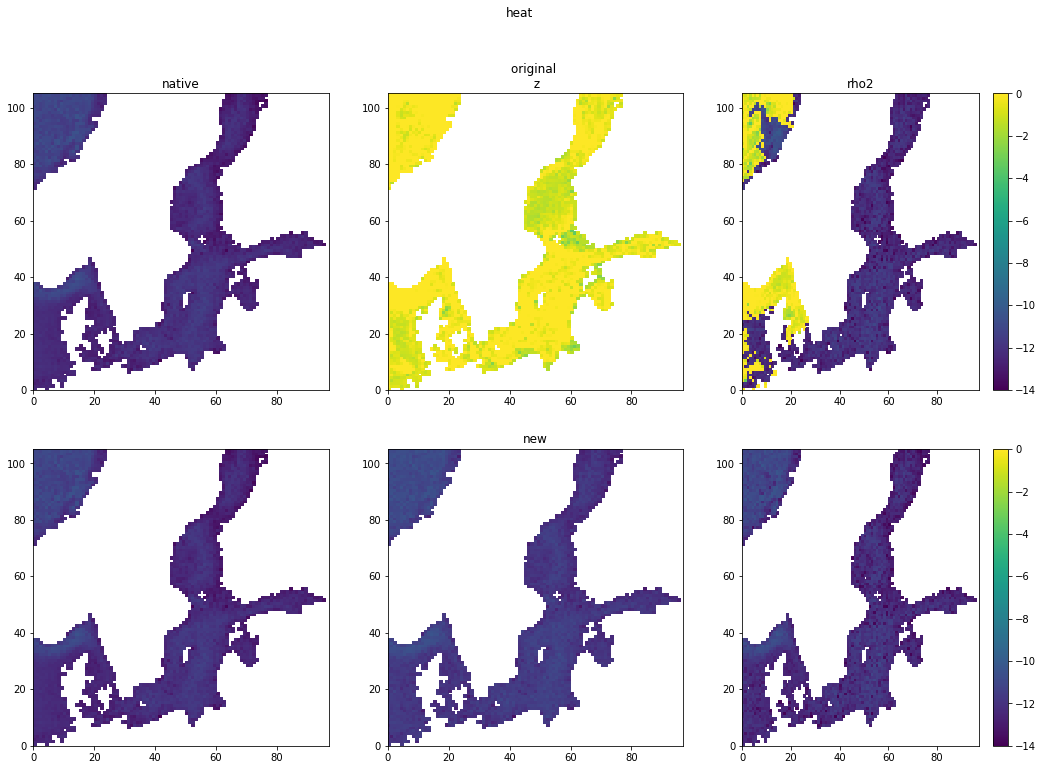

In [106]:
# Comparative plot
fig,((ax_orig_native,ax_orig_z,ax_orig_rho2),(ax_new_native,ax_new_z,ax_new_rho2)) = plt.subplots(figsize=(18,12),ncols=3,nrows=2)
fig.suptitle('heat')

im = ax_orig_native.pcolormesh(np.log10(rmse_heat_native))
ax_orig_native.set_title('native')
im.set_clim([-14,0])
im = ax_orig_z.pcolormesh(np.log10(rmse_heat_z))
ax_orig_z.set_title('original \n z')
im.set_clim([-14,0])
im = ax_orig_rho2.pcolormesh(np.log10(rmse_heat_rho2))
ax_orig_rho2.set_title('rho2')
im.set_clim([-14,0])
plt.colorbar(im,ax=ax_orig_rho2)

im = ax_new_native.pcolormesh(np.log10(rmse_heat_native_new))
im.set_clim([-14,0])
im = ax_new_z.pcolormesh(np.log10(rmse_heat_z_new))
ax_new_z.set_title('new')
im.set_clim([-14,0])
im = ax_new_rho2.pcolormesh(np.log10(rmse_heat_rho2_new))
im.set_clim([-14,0])
plt.colorbar(im,ax=ax_new_rho2)